In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pulse2percept.datasets import load_perezfornos2012
import time
import pulse2percept as p2p
from pulse2percept.models import TemporalModel
from pulse2percept.stimuli.pulse_trains import BiphasicPulseTrain
from scipy.optimize import minimize, differential_evolution
from IPython.display import display, clear_output
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

# from IPython.display import clear_output, displayimport time

data = load_perezfornos2012()


class Args():
  stim_dur = 0
  amplitude = 10
  pulse_dur = 0.46
args = Args()

In [7]:
def y_rise(t, A, k_rise, t_start):
    return k_rise * (t - t_start)

def y_slow_decline(t, B, k_decline1, t_peak1):
    return B *  np.exp(-(args.stim_freq)**(1/4) * k_decline1 * (t - t_peak1))

def y_sharp_drop(t, C, k_decline2, t_peak2):
    return C * np.exp(-k_decline2 * (t - t_peak2))

def y_very_slow_decline(t, D, k_decline3, t_end_fast_decline, alpha, A):
    return  D*k_decline3 * np.sin( alpha*(t - t_end_fast_decline))

def response(t, t_peak1, t_end_fast_decline, A, k_rise, t_start, k_decline1, k_decline2,k_decline3, prev_y, alpha, t_peak2, t_stop):
    if t <= t_peak1:
        return y_rise(t, A, k_rise, t_start)
    elif t_peak1 < t <= t_peak2:
        return y_slow_decline(t, prev_y, k_decline1, t_peak1)
    elif t_peak2 < t <= t_end_fast_decline:
        return y_sharp_drop(t, prev_y, k_decline2, t_peak2)
    elif t_end_fast_decline < t <= t_stop:
        return y_very_slow_decline(t, prev_y, k_decline3, t_end_fast_decline, alpha, A)
    else:
        return y_sharp_drop(t, prev_y, k_decline2, t_stop)

def brightness(t_values, stim, t_start, t_peak1, t_end_fast_decline, k_rise, k_decline1, k_decline2, k_decline3, alpha, t_peak2, t_stop):
    t_end_fast_decline = t_end_fast_decline  + args.stim_dur
    t_stop = args.exper_dur - t_stop

    y_values = []
    for t_idx in range(len(t_values)):
      A = stim[t_idx]
      t = t_values[t_idx]
      if t<=t_start: y_values.append(0)
      else:
        if len(y_values)!=0: prev_y = y_values[-1]
        else: prev_y = 0
        y_values.append(response(t, t_peak1, t_end_fast_decline, A, k_rise, t_start, k_decline1, k_decline2,k_decline3, prev_y, alpha, t_peak2, t_stop))
    y_values_ = [min(x, 10) for x in y_values]
    return y_values_

def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)

    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

def loss(params, t_lst,stim_lst, gt_curves_train, stim_dur_lst):
    total_mse = 0
    for y_idx in range(len(gt_curves_train)):
        args.stim_dur = stim_dur_lst[y_idx][0]
        args.exper_dur = stim_dur_lst[y_idx][1]
        args.stim_freq = stim_dur_lst[y_idx][2]

        y_predicted = brightness(t_lst[y_idx],stim_lst[y_idx], *params)

        total_mse += np.mean((y_predicted - gt_curves_train[y_idx]) ** 2 )
    return total_mse/len(gt_curves_train)

def eval(params, t_lst,stim_lst, gt_curves_train, stim_dur_lst):
    total_mse = 0
    y_predicted_lst = []
    for y_idx in range(len(gt_curves_train)):
        args.stim_dur = stim_dur_lst[y_idx][0]
        args.exper_dur = stim_dur_lst[y_idx][1]
        args.stim_freq = stim_dur_lst[y_idx][2]
        y_predicted = brightness(t_lst[y_idx],stim_lst[y_idx], *params)
        y_predicted_lst.append([y_predicted,  gt_curves_train[y_idx]])
    return y_predicted_lst

### 0.25 interp

In [8]:
import pandas as pd
data = pd.read_csv('perez-fornos-2012.csv')  

stim_info = {}  # stim_dur(ms), freq, exper_dur(s)
for i in range(9): stim_info[i] = [20000*2, 20, 60*2]
for i in range(9,18): stim_info[i] = [20000*2, 5, 60*2]
for i in range(18,27): stim_info[i] = [20000*2, 60, 60*2]
for i in range(27,36): stim_info[i] = [2000*2, 20, 20*2]
for i in range(36,45): stim_info[i] = [120000*2, 20, 140*2]

biphasic_info = {}
for i in stim_info.keys():
  clear_output(wait=False)
  # display(' Progress: '+str(i+1)+'/'+str(45))
  print(i+1)
  stim_dur = stim_info[i][0]
  stim_freq = stim_info[i][1]
  exper_dur = stim_info[i][2]
  biphasic = p2p.implants.ArgusII(stim = {'A5' : p2p.stimuli.BiphasicPulseTrain(
                                                          stim_freq,
                                                          args.amplitude,
                                                          args.pulse_dur,
                                                          stim_dur=stim_dur)})
  biphasic_info[i] = biphasic

45


In [42]:
# set seed; this is for randomly picking the inital values
np.random.seed(42)

for cond in range(0,5):
    for subj in range(0,9):
        panel_idx = cond*9 + subj
        idx_lst = [cond*9 + sub for sub in range(9)]
        idx_lst.remove(panel_idx)

        if panel_idx!=19: pass
        else:
          args.stim_dur = stim_info[panel_idx][0]
          args.stim_freq = stim_info[panel_idx][1]
          args.exper_dur = stim_info[panel_idx][2]

          gt_curves_train = [np.nan_to_num(data.iloc[idx, 6:args.exper_dur+6].to_numpy().astype('float64'), 0) for idx in idx_lst]  # 8 curves
          gt_curves_val = np.nan_to_num(data.iloc[panel_idx, 6:args.exper_dur+6].to_numpy().astype('float64'), 0)  # 1 curve
            
          # stimulus
          biphasic = biphasic_info[panel_idx]
          args.stim_dur=args.stim_dur//1000
          stim = np.abs(biphasic.stim.data)[0]
          stim = np.tile(stim, 100*args.stim_dur)[:args.stim_dur*1000]
          stim = stim.reshape(-1, len(stim)//args.stim_dur)
          stim = stim.sum(axis=1)
          stim = np.cumsum(stim)
          stim = np.append(stim, np.array([np.max(stim)]*(len(gt_curves_val)-len(stim))))
          stim = stim/10000

          t_values = np.linspace(0, len(gt_curves_val)-1, len(gt_curves_val))
          skip = len(t_values)  # no skipping values

          eps = [1, 1, 1,
                0.01, 0.01,0.001,0.001,
                0.01,1 ]

          final_value_bounds = [
              (-np.inf, np.inf),  # t_start
              (-np.inf, np.inf),  # t_peak1
              (-np.inf, np.inf),  # t_end_fast_decline
              (0, np.inf),  # k_rise
              (0, np.inf),   # k_decline1
              (0, np.inf),   # k_decline2
              (0, np.inf),   # k_decline3
              (-np.inf, np.inf),   # alpha
              (-np.inf, np.inf),  # t_peak2
              (-np.inf, np.inf)  # t_stop
          ]

          # Define the boundaries for each parameter
          bounds = [
              (0, 10*2),  # t_start
              (0, 5*2),  # t_peak1
              (-20*2, 20*2),  # t_end_fast_decline
              (5, 10),  # k_rise
              (0, 10),   # k_decline1
              (0, 1),   # k_decline2
              (0, 1),   # k_decline3
              (0, 6),   # alpha
              (0, 20*2),  # t_peak2
              (0, 10*2)  # t_stop
          ]

          # Number of initial parameter sets to generate
          num_tests = 1000

          # Generate initial parameter sets
          initial_params_sets = np.random.uniform(
              [low for (low, high) in bounds],
              [high for (low, high) in bounds],
              (num_tests, len(bounds))
          )

          # Store the best parameters and their corresponding MSE
          best_params = None
          best_mse = float('inf')
          lst = []

          # Loop through each set of initial parameters
          start_time = time.time()
          ct = 0
          ct_patience = 0

          stim_lst = []
          t_values_lst = []
          stim_dur_lst = []
          idx_condition = 0
          for idx in idx_lst:
              biphasic = biphasic_info[idx]
              stim_dur = stim_info[idx][0]
              stim_freq = stim_info[idx][1]
              exper_dur = stim_info[idx][2]

              stim_lst.append(stim)

              t_values_ = np.linspace(0, len(gt_curves_train[idx_condition])-1, len(gt_curves_train[idx_condition]))
              t_values_lst.append(t_values_)
              stim_dur_lst.append([stim_dur,exper_dur, stim_freq])

              idx_condition += 1

          for initial_params in initial_params_sets:
              ct += 1
              print(ct, end='\r')

              params = minimize(loss, initial_params, args=(t_values_lst, stim_lst, gt_curves_train, stim_dur_lst),
                                # options={"eps": eps}, method="Nelder-Mead", bounds=final_value_bounds).x
                                 options={"eps": eps}, method="Powell", bounds=final_value_bounds).x
                                  # method="TNC").x
                                
                                
              mse = loss(params, t_values_lst,stim_lst, gt_curves_train, stim_dur_lst)
              
              lst.append(best_mse)
              
              if mse < best_mse:
                  best_mse = mse
                  best_params = params
                  ct_patience = 0
              else:
                  ct_patience += 1
                  if ct_patience >= 10: break

          # Print and plot results using the best parameters
          print('Best parameters:',panel_idx)
          name_lst = ['t_start', 't_peak1', 't_end_fast_decline', 'k_rise', 'k_decline1', 'k_decline2', 'k_decline3', 'alpha', 't_peak2', 't_stop']
          for i in range(len(best_params)):
              print(name_lst[i], best_params[i])
          print('mse: ', best_mse)
          print('time: ', round((time.time() - start_time), 3))

          file_path = 'per-subject-freq-025interp.txt'
          line_to_add = ''
          line_to_add += str(panel_idx) + ': '
          line_to_add += str(list(best_params)) + '\n'
          with open(file_path, 'a') as file:
              file.write(line_to_add)

Best parameters: 19
t_start -1.2344582620383346
t_peak1 8.886339456732866
t_end_fast_decline 43.26207901202839
k_rise 1.0002068103265944
k_decline1 1.6370686038431108
k_decline2 135784.4310022864
k_decline3 138564.63495457926
alpha 19.81520633778807
t_peak2 29.599799882615674
t_stop 22.49125055195548
mse:  9.302554970656908
time:  3.704


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


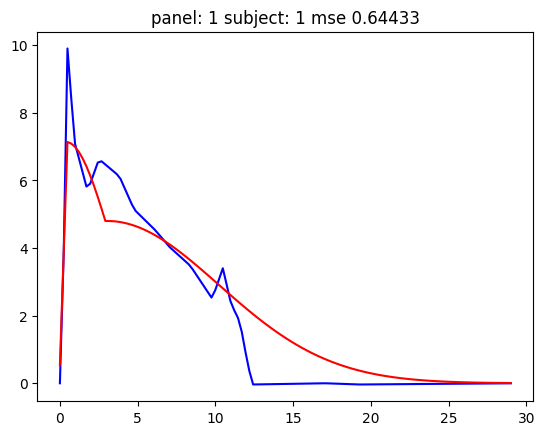

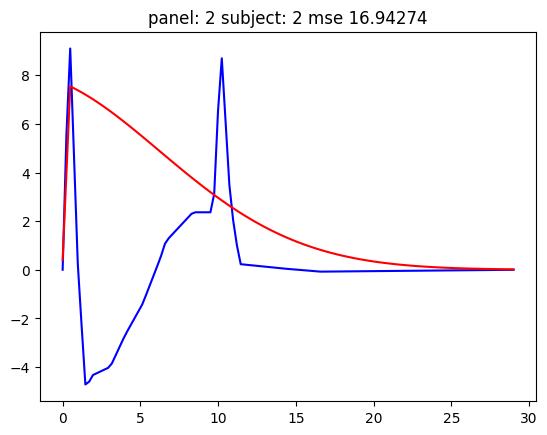

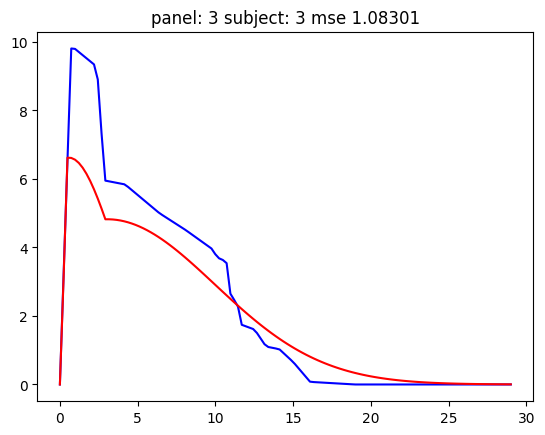

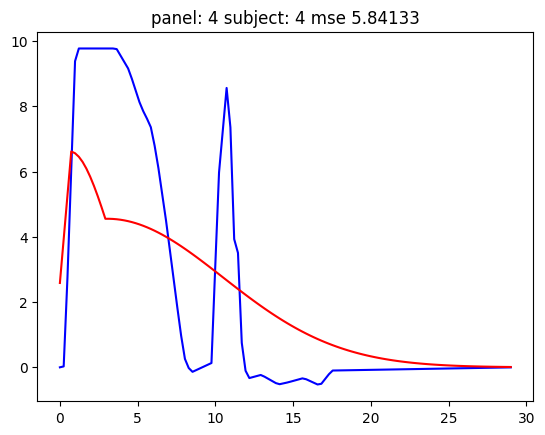

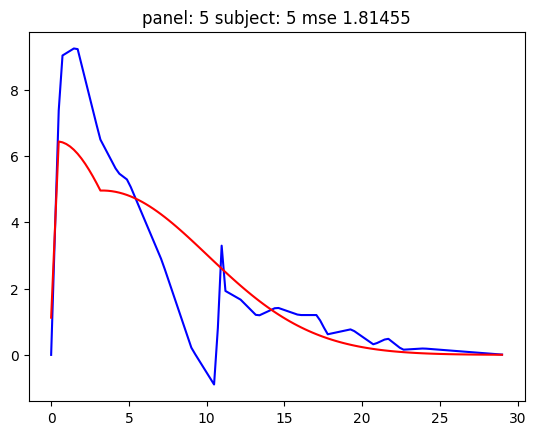

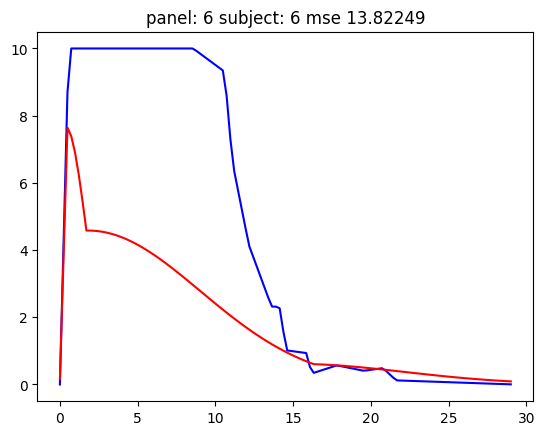

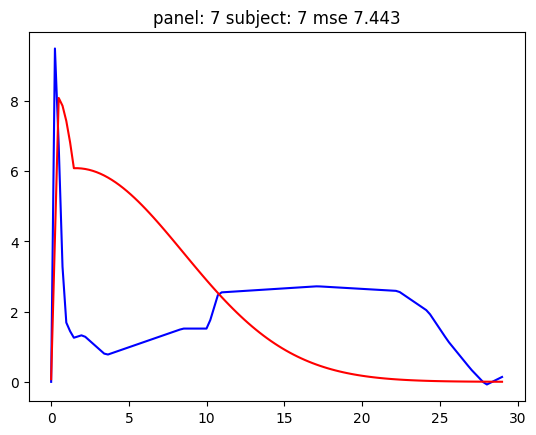

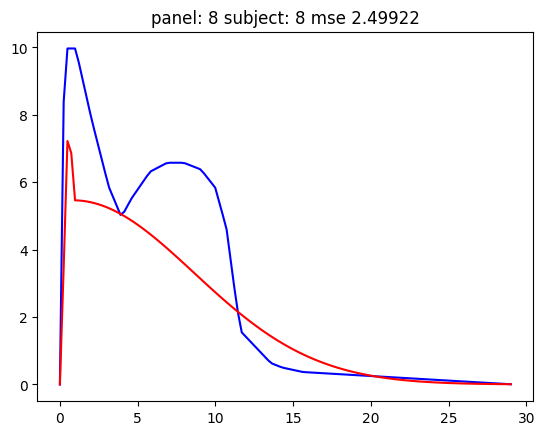

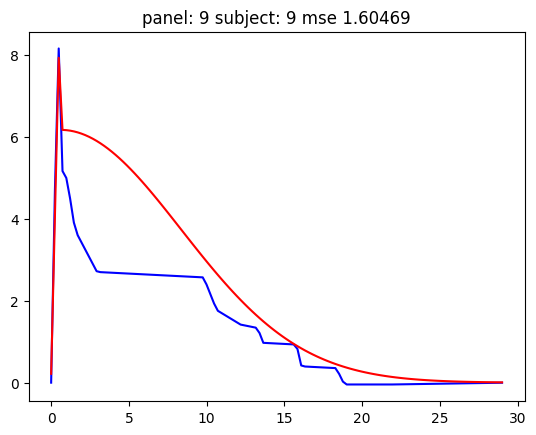

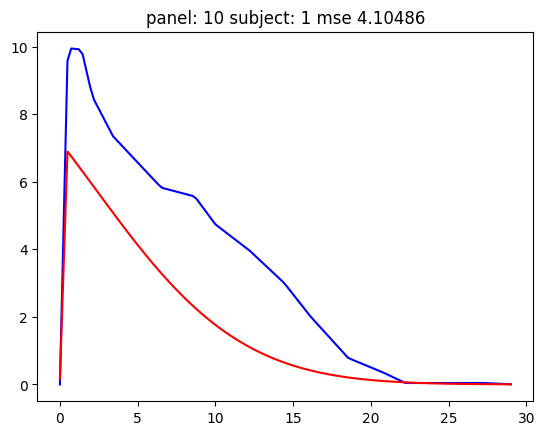

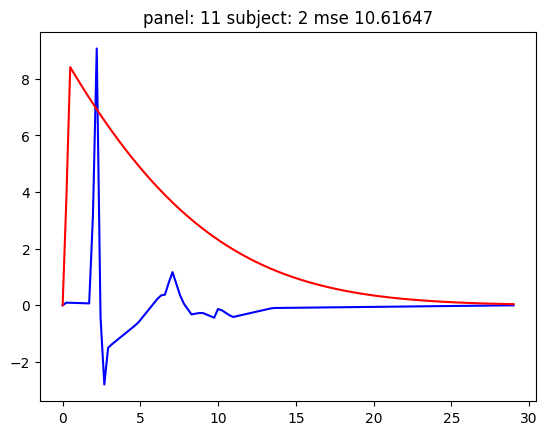

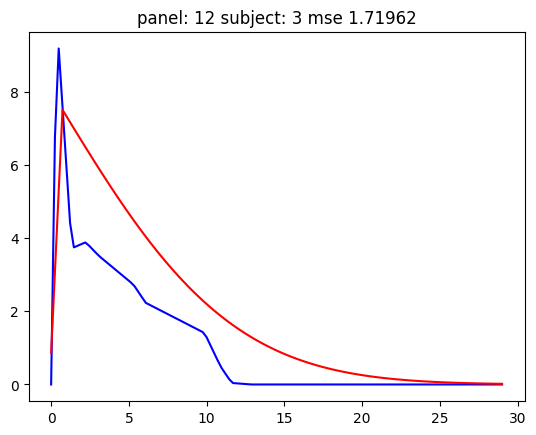

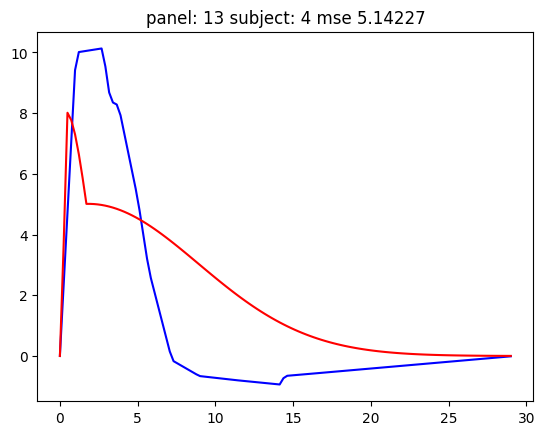

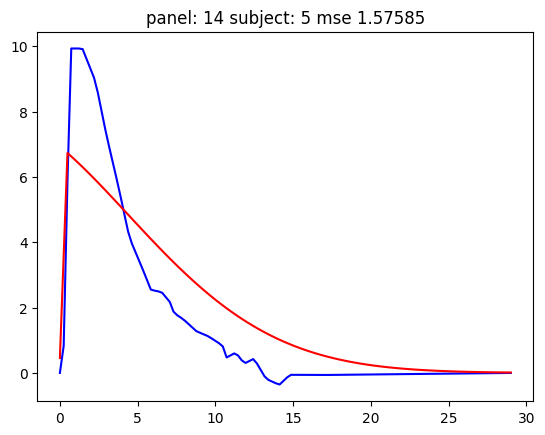

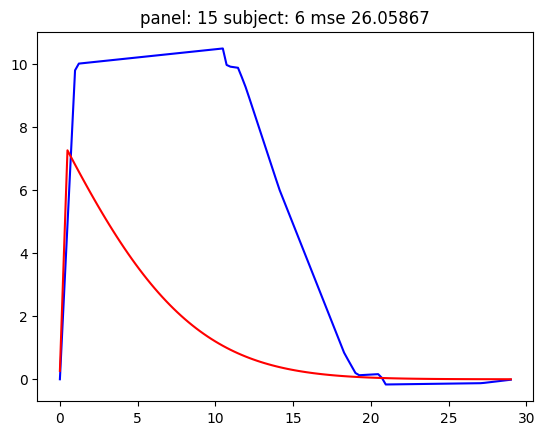

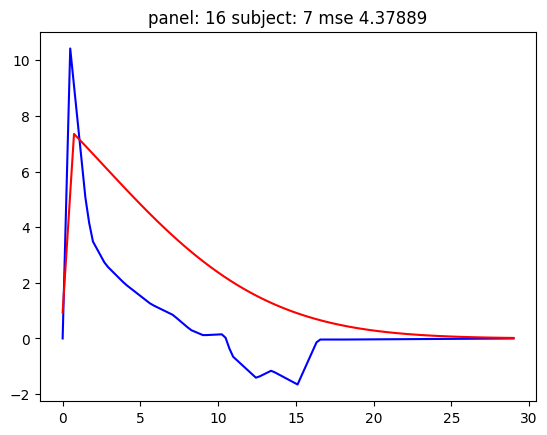

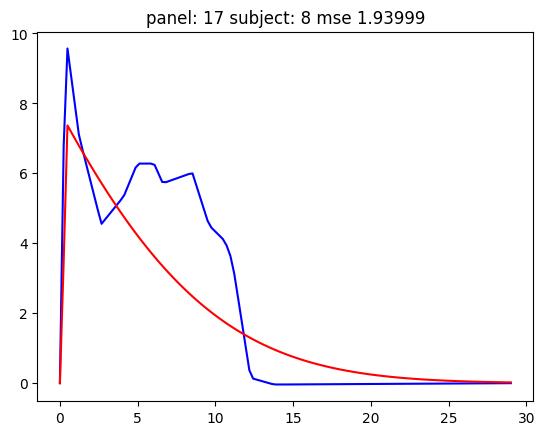

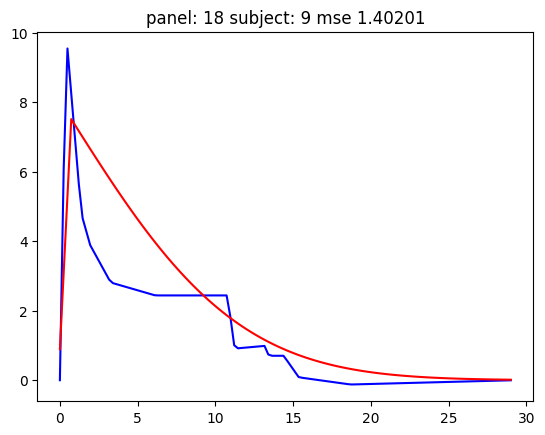

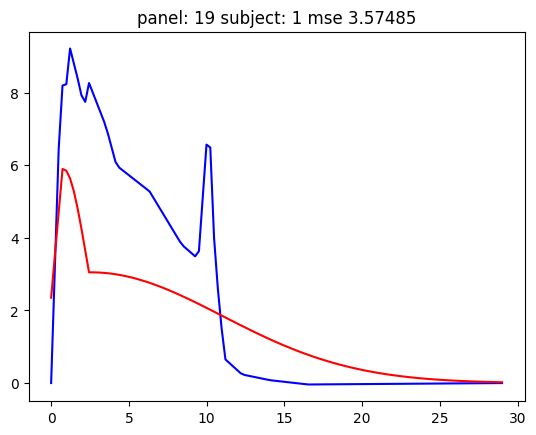

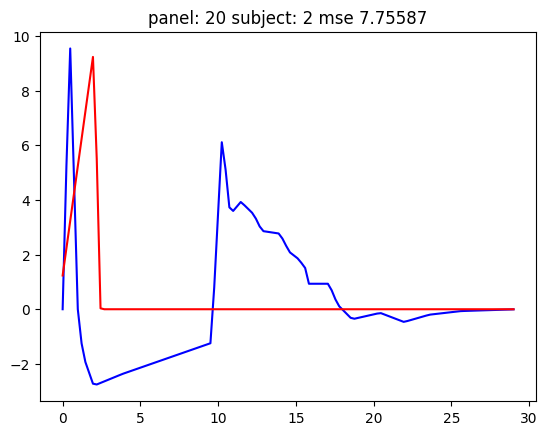

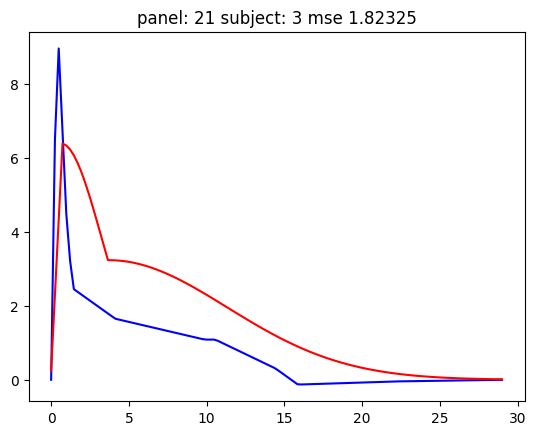

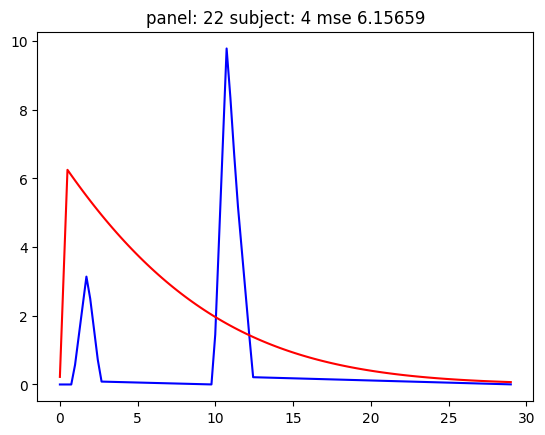

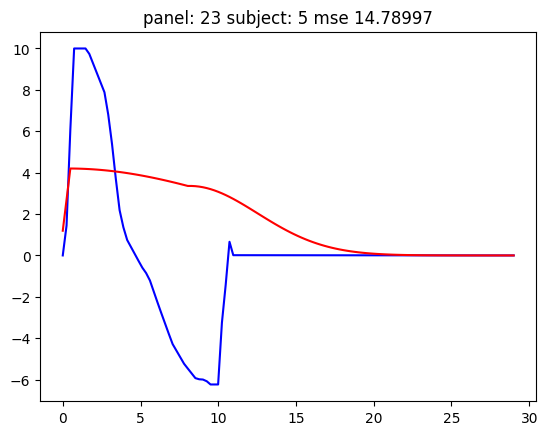

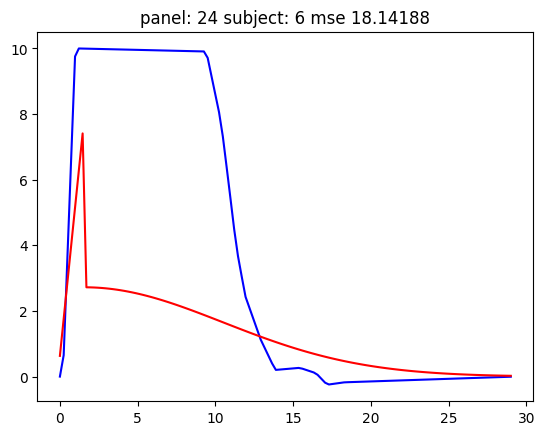

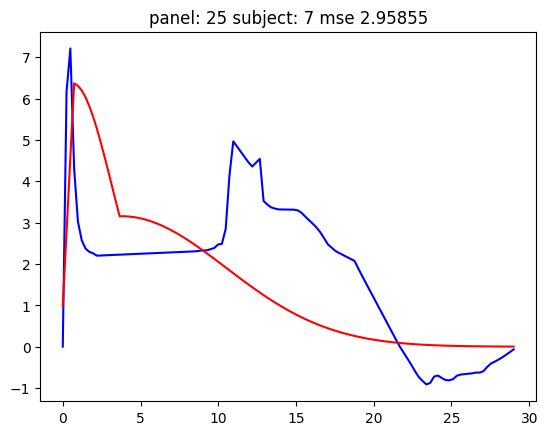

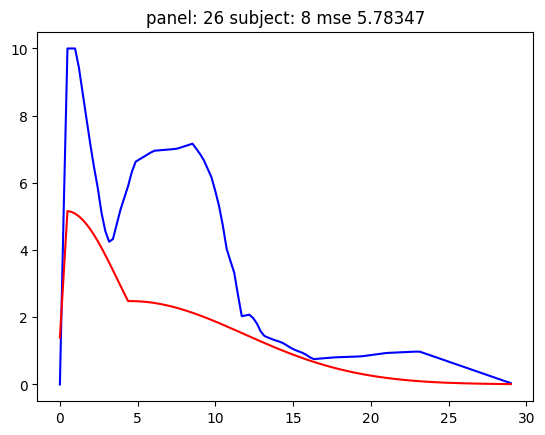

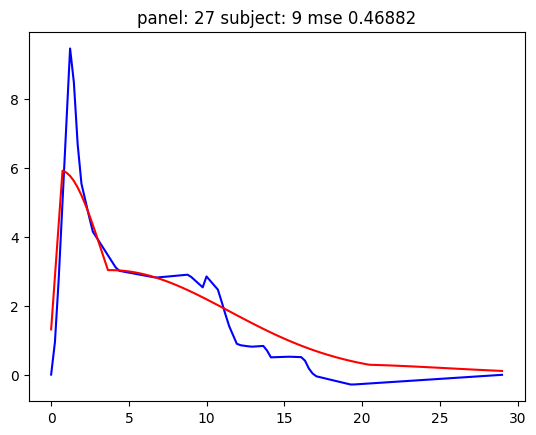

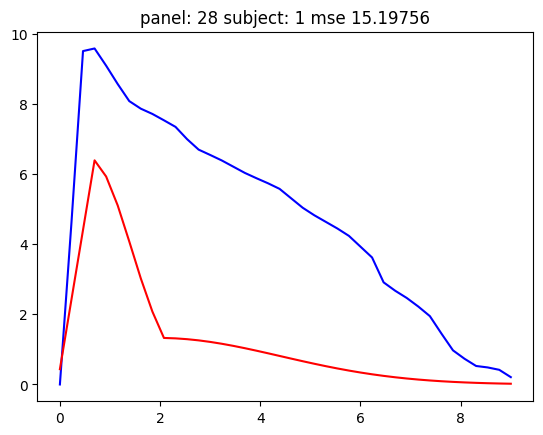

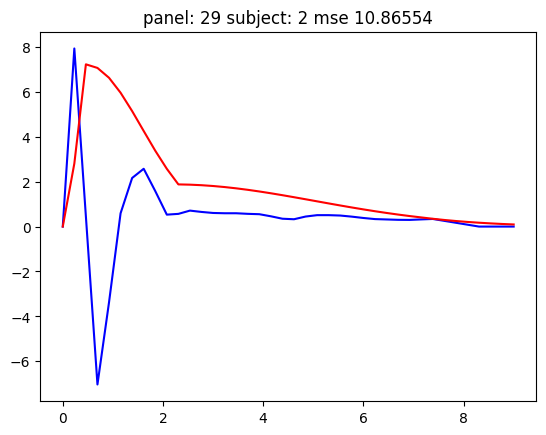

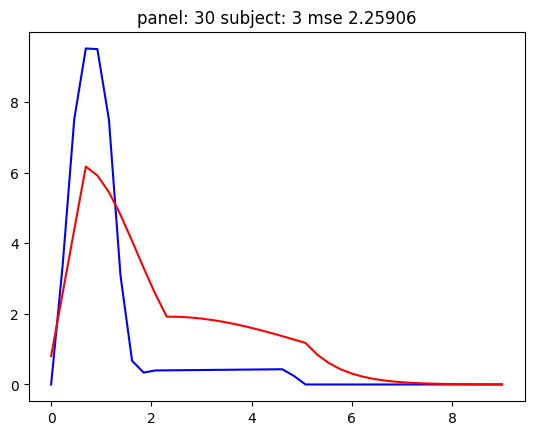

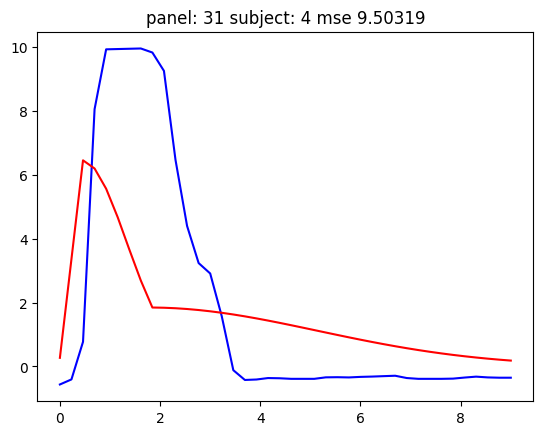

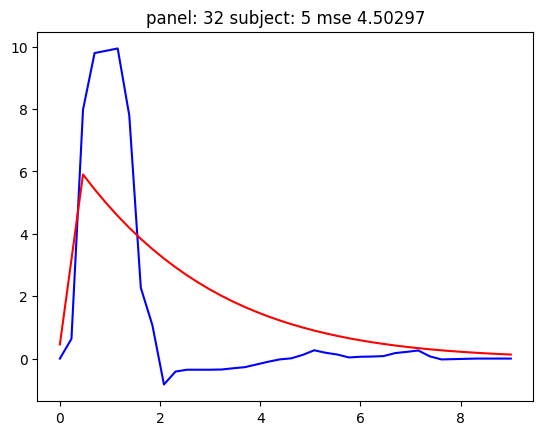

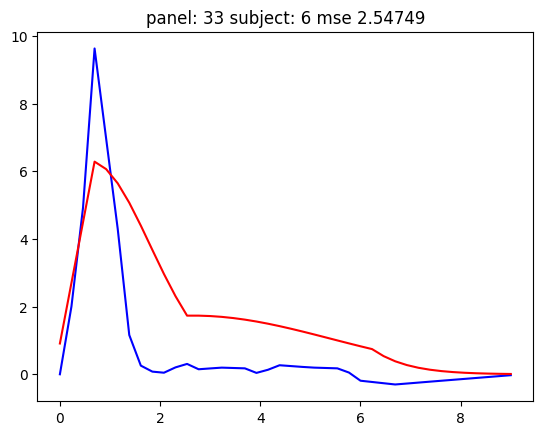

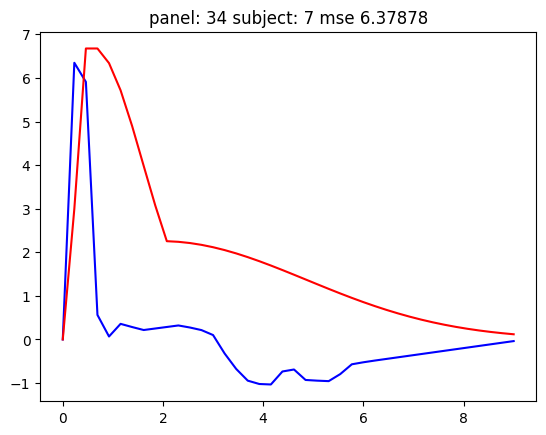

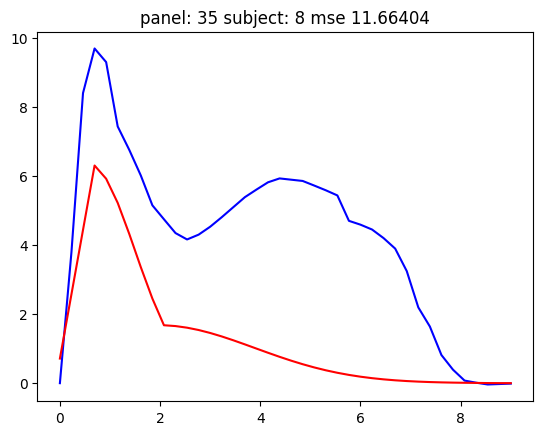

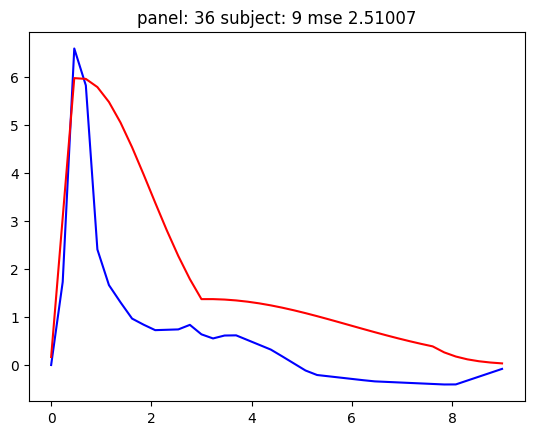

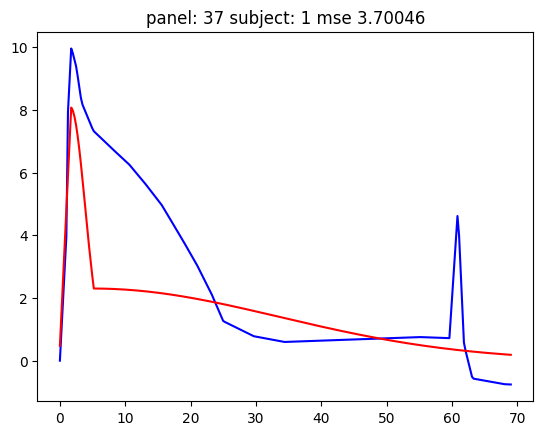

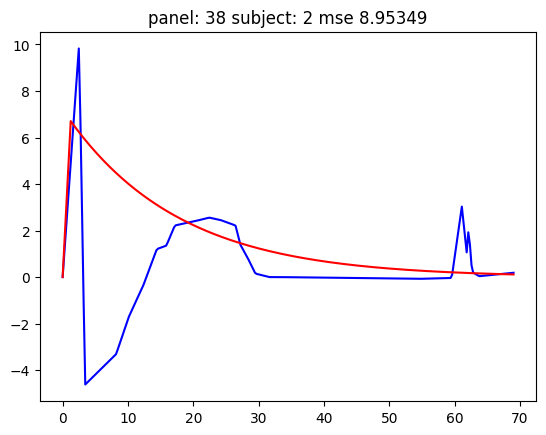

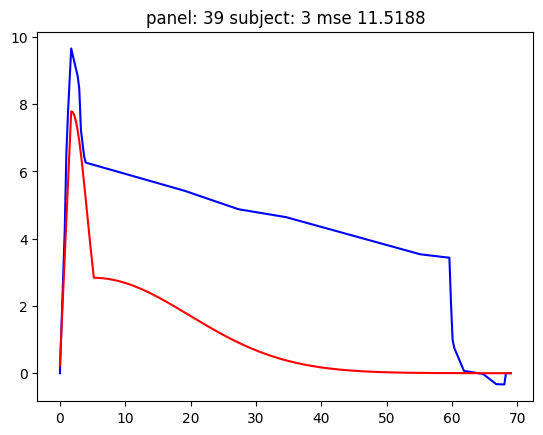

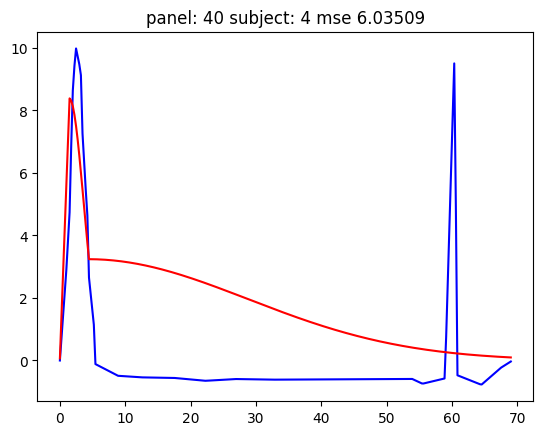

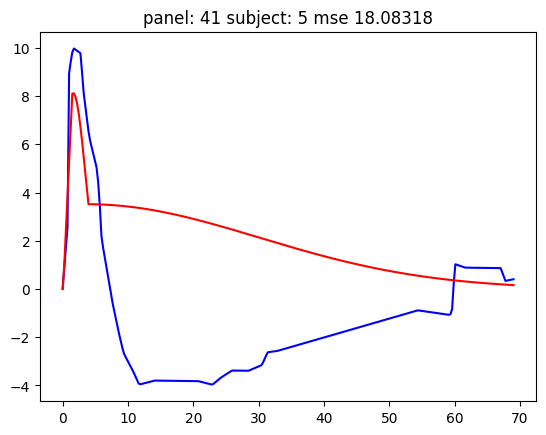

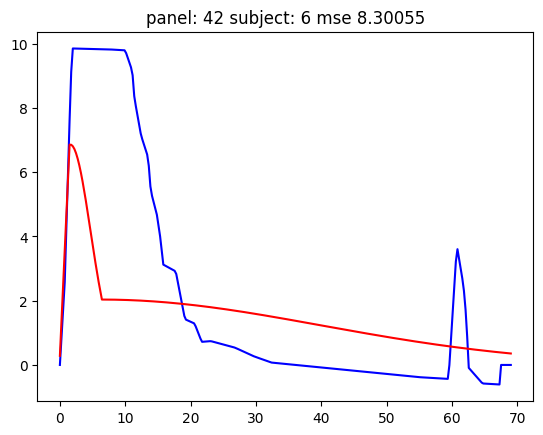

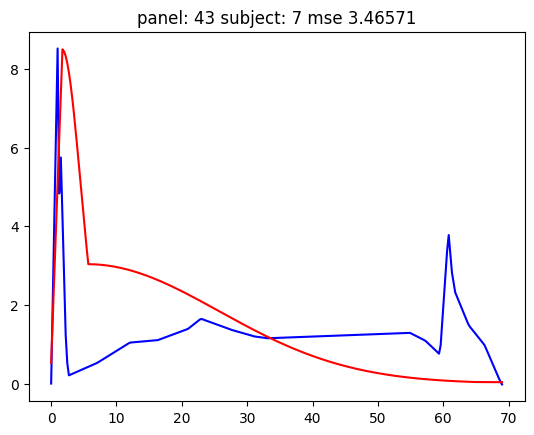

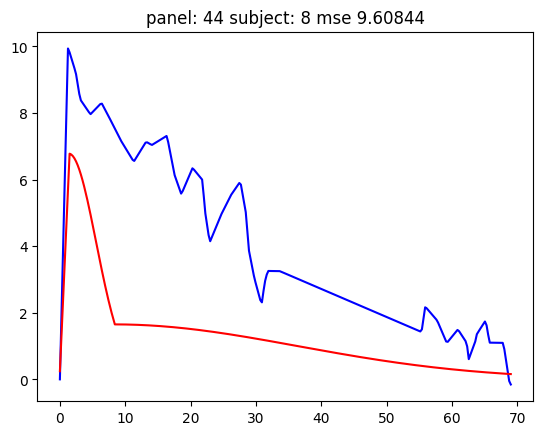

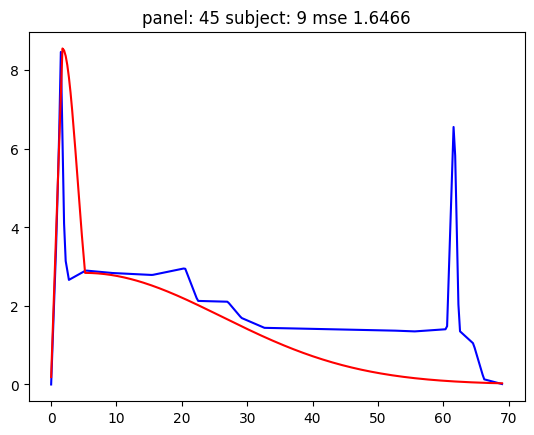

In [45]:
file_path = 'per-subject-freq-025interp.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        key = int(key)
        value_string = value.strip(" []")
        value_list = [float(num.split(',')[0]) for num in value_string.split()]
        results_dict[key] = value_list

# validation score
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)

    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

ct = 0
mse = {}
cor = {}
r2 = {}

for cond in range(0,5):
    for subj in range(9):
        panel_idx = cond*9 + subj
        if panel_idx ==-1: pass
        else:
            print(panel_idx)
            idx_lst = list(range(cond*9 , (cond+1)*9))
            idx_lst.remove(panel_idx)
    
            args.stim_dur = stim_info[panel_idx][0]
            args.stim_freq = stim_info[panel_idx][1]
            args.exper_dur = stim_info[panel_idx][2]
    
            # gt_curves_train = [np.nan_to_num(data['time_series'][idx], 0)[4:stim_info[idx][2]+4] for idx in idx_lst]  # 8 curves
            # gt_curves_val = np.nan_to_num(data['time_series'][panel_idx], 0)[4:args.exper_dur+4]  # 1 curve
            gt_curves_val = np.nan_to_num(data.iloc[panel_idx, 6:args.exper_dur+6].to_numpy().astype('float64'), 0)
    
            params = results_dict[panel_idx]
            
            t_values = np.linspace(0, len(gt_curves_val)-1, len(gt_curves_val))
            biphasic = biphasic_info[panel_idx]
            args.stim_dur=args.stim_dur//1000
            stim = np.abs(biphasic.stim.data)[0]
            stim = np.tile(stim, 100*args.stim_dur)[:args.stim_dur*1000]
            stim = stim.reshape(-1, len(stim)//args.stim_dur)
            stim = stim.sum(axis=1)
            stim = np.cumsum(stim)
            stim = np.append(stim, np.array([np.max(stim)]*(len(gt_curves_val)-len(stim))))
            stim = stim/10000
    
            pred = brightness(t_values, stim, *params)
            pred_ = [max(-4, x) for x in pred]
            pred = np.nan_to_num(pred_, 0)

            plt.figure()
            plt.plot(np.linspace(0, args.exper_dur//4-1, args.exper_dur), gt_curves_val, color='blue')
            plt.plot(np.linspace(0, args.exper_dur//4-1, args.exper_dur), pred, color='red')
            
            mse[panel_idx] = mean_squared_error(gt_curves_val, pred)
            plt.title('panel: ' + str(panel_idx+1) +  ' subject: '+ str(subj+1) + ' mse '+str(round(mse[panel_idx], 5)))
            r2[panel_idx] = r2_score(gt_curves_val, pred)
            cor[panel_idx] = corr(gt_curves_val, pred)
# 12.35

In [46]:
for cond in range(0,5):
    mse_,r2_,cor_ = [],[],[]
    for subj in range(9):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('cond', cond)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3) , end=' ')
    # print(round(np.mean(r2_), 3),  round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3),  '+-', round(np.std(cor_), 3))

5.744 +- 5.621 0.686 +- 0.433
6.327 +- 7.492 0.757 +- 0.255
6.828 +- 5.626 0.566 +- 0.372
7.27 +- 4.455 0.625 +- 0.315
7.924 +- 4.724 0.512 +- 0.303


In [48]:
for subj in range(9):
    mse_,r2_,cor_ = [],[],[]
    for cond in range(5):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('subject', subj)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3), end = ' ')
    # print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

5.444 +- 5.03 0.882 +- 0.075
11.027 +- 3.168 -0.083 +- 0.101
3.681 +- 3.937 0.842 +- 0.091
6.536 +- 1.525 0.583 +- 0.248
8.153 +- 6.92 0.604 +- 0.307
13.774 +- 8.074 0.778 +- 0.084
4.925 +- 1.717 0.346 +- 0.295
6.299 +- 3.833 0.853 +- 0.08
1.526 +- 0.651 0.857 +- 0.1


In [54]:
print(round(np.mean([i for i in mse.values()]), 3), '+-', round(np.std([i for i in mse.values()]), 3))
print(round(np.mean([i for i in cor.values()]), 3), '+-', round(np.std([i for i in cor.values()]), 3))


6.818 +- 5.733
0.629 +- 0.352
